# Task 2: A/B testing

In this notebook, you configure an A/B testing strategy, test model variants, and review the performance of the model variants.

## Task 2.1: Environment setup

Install the required libraries and dependencies.

In [16]:
%%capture
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
import pandas as pd
import numpy as np
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.image_uris import retrieve
from sagemaker.session import production_variant
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

region = boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")
cw = boto3.Session().client("cloudwatch")

bucket = sm_session.default_bucket()
prefix = 'sagemaker/abalone'

## Task 2.2: Create an endpoint

Your company just finished creating a new model they want to test. In this lab, you upload the new model to an Amazon Simple Storage Service (Amazon S3) bucket with the current model that is in production. Then, you create model variants. Finally, you create an endpoint with the production variants.

First, upload the models to the Amazon S3 bucket. The current model in production is *model_A.tar.gz*, and the new model is *model_B.tar.gz*.

In [2]:
#upload-models
model_url = S3Uploader.upload(
    local_path="models/model_A.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url2 = S3Uploader.upload(
    local_path="models/model_B.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url, model_url2

('s3://sagemaker-us-west-2-916235518742/sagemaker/abalone/model_A.tar.gz',
 's3://sagemaker-us-west-2-916235518742/sagemaker/abalone/model_B.tar.gz')

Next, create model definitions for the pre-trained abalone models.

In [3]:
#create-model-definitions
model_name = f"abalone-A-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"abalone-B-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = retrieve("xgboost", boto3.Session().region_name, "1.5-1")
image_uri2 = retrieve("xgboost", boto3.Session().region_name, "1.5-1")

response = sm_session.create_model(
    name=model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": model_url}
)

response_2 = sm_session.create_model(
    name=model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": model_url2}
)

print(response)
print(response_2)

abalone-A-2025-06-18-16-47-49
abalone-B-2025-06-18-16-47-49


Then, create two variants, each with its own model. Set *initial_weight* to 1 for both variants so 50 percent of the requests go to **Production-Model-A** and 50 percent of the requests go to **New-Model-B**.

To create a production variant, you must configure the following options:
- **model_name**: The name of the model that you want to host. You specified this name when you created the model.
- **instance_type**: The compute instance type.
- **initial_instance_count**: The number of instances to launch initially.
- **variant_name**: The name of the production variant (one or more models in production).
- **initial_weight**: The starting weight for each variant.

In [4]:
#create-production-variants
variant1 = production_variant(
    model_name=model_name,
    instance_type="ml.m5.large",
    initial_instance_count=4,
    variant_name="Production-Model-A",
    initial_weight=1,
)
variant2 = production_variant(
    model_name=model_name2,
    instance_type="ml.m5.large",
    initial_instance_count=4,
    variant_name="New-Model-B",
    initial_weight=1,
)

(variant1, variant2)

({'VariantName': 'Production-Model-A',
  'ModelName': 'abalone-A-2025-06-18-16-47-49',
  'InitialVariantWeight': 1,
  'InitialInstanceCount': 4,
  'InstanceType': 'ml.m5.large'},
 {'VariantName': 'New-Model-B',
  'ModelName': 'abalone-B-2025-06-18-16-47-49',
  'InitialVariantWeight': 1,
  'InitialInstanceCount': 4,
  'InstanceType': 'ml.m5.large'})

Finally, create an endpoint with the two variants.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint creation takes approximately 4–5 minutes to complete.

In [5]:
#create-endpoint
endpoint_name = f"Abalone-{datetime.now():%Y-%m-%d-%H-%M-%S}"

sm_session.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant1, variant2]
)

------!

'Abalone-2025-06-18-16-48-34'

When the cell completes, an endpoint name is returned that looks like *Abalone-2025-01-01-01-01-00*.

## Task 2.3: Evaluate invocation metrics

Amazon SageMaker emits metrics such as latency and invocations for each variant in Amazon CloudWatch. To test the endpoint, invoke the deployed models and evaluate the invocation metrics. You can send data to the endpoint that you created in the prior task to get inferences in real time. The data science team received a new set of data and sent it to you. Test the models by using this new data.

First, get a subset of the test data for a sample of the invocation.

In [6]:
#import-data
shape=pd.read_csv("data/abalone_data_test.csv", header=0)
shape.sample(5)

,0.384,0.301,0.11,0.35,0.098,0.058,0.137,1,0,0.1
828,0.299,0.231,0.077,0.116,0.001,0.003,0.119,0,0,1
1968,0.384,0.293,0.100,0.417,0.147,0.078,0.127,0,0,1
1381,0.624,0.519,0.173,0.717,0.240,0.156,0.253,0,1,0
1157,0.628,0.457,0.179,1.258,0.593,0.301,0.348,0,0,1
1044,0.607,0.461,0.174,1.240,0.603,0.263,0.371,0,1,0


Then, send traffic to the endpoint by using **invoke_endpoint**.

<i class="fas fa-sticky-note" style="color:#ff6633"></i> **Note:** The endpoint invocation takes approximately 1–2 minutes to complete.

In [7]:
#send-test-data
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("data/abalone_data_test.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
f.close()
print("Done!")

Sending test traffic to the endpoint Abalone-2025-06-18-16-48-34. 
Please wait...
Done!


To show how invocations are split across variants, query the number of invocations per variant from CloudWatch.

Waiting a minute for initial metric creation...


,Production-Model-A,New-Model-B
Timestamp,,
2025-06-18 16:52:00+00:00,552.0,568.0
2025-06-18 16:53:00+00:00,451.0,428.0


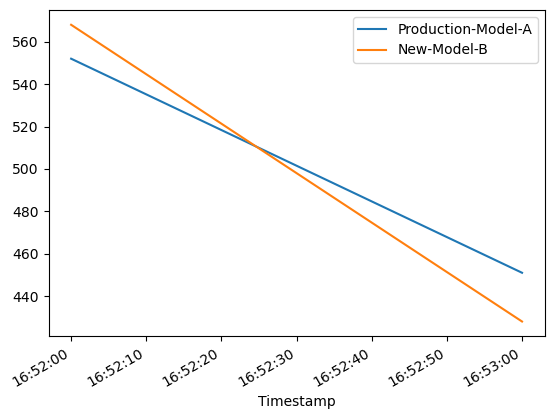

In [8]:
#get-cloudwatch-metrics
def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant1["VariantName"], start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant2["VariantName"], start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

The table reports the number of invocations for Model A, the production model. It also reports the number of invocations for Model B, the new model. The chart plots the number of invocations per model variant over a period of time. The table and chart indicate that traffic is distributed evenly between the two variants.

When you are conducting A/B testing, you can invoke a specific variant by specifying the *TargetVariant* when calling *invoke_endpoint*. Invoke the variant that is currently in production, **Production-Model-A**.

In [10]:
#get-model-A-predictions
predictions = ""

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("data/abalone_data_test.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant1["VariantName"],
        )
        predictions = ",".join([predictions, response["Body"].read().decode("utf-8")])
f.close()

# Convert the predictions to a numpy array and round the values
pred_np = np.fromstring(predictions[1:], sep=",")
preds = np.round(pred_np)

print("Done!")

Sending test traffic to the endpoint Abalone-2025-06-18-16-48-34. 
Please wait...
Done!


Check the traffic per variant again. This time, you see that the number of invocations only incremented for *Production-Model-A* because all of the invocations were targeted at that variant.

,Production-Model-A,New-Model-B
Timestamp,,
2025-06-18 16:52:00+00:00,552.0,568.0
2025-06-18 16:53:00+00:00,451.0,429.0
2025-06-18 16:54:00+00:00,2209.0,0.0


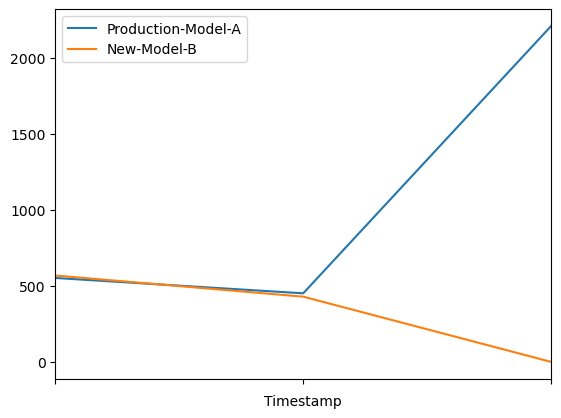

In [11]:
#plot-model-A-metrics
time.sleep(20)  # let metrics catch up
plot_endpoint_metrics()

## Task 2.4: Evaluate the models with production data

To see if the new model is an improvement over the one currently in production, evaluate both models and compare their results. Using a list of predicted values, you can evaluate the R-Squared Score (R2 score), mean absolute error (MAE), and root mean square error (RMSE) metrics for each variant. These metrics help to determine whether the new model is an improvement over the one currently in production.

Metric definitions:
- **R2 score:** The R2 score compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). The R2 score can range from -Infinity to 1. A negative R2 score means the model is a poor fit for the data. A higher positive score indicates a better fit.
- **MAE:** The difference between the actual and predicted values, divided by the total number of points in the dataset. It helps you to determine how close the predictions are to the actual model on average.
- **RMSE:** The square root of the difference between the actual and predicted values. It helps you to determine whether the predictions have any large errors, either as overestimation or underestimation.

As a reminder, the models predict the number of rings of an abalone based on a set of features. These predictions are used to estimate how old an abalone is without damaging it. Each ring is equivalent to a year of life, much like the rings of a tree. The predicted values are the number of rings that the model estimates an abalone has.

To start, evaluate the first variant, **Production-Model-A**, with the prediction values that were collected in the prior task. 

In [17]:
#evaluate-model-A-metrics
df_with_labels = pd.read_csv("data/abalone_data_new.csv", header=None)
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()
print("The predicted values are:\n {}\n".format(preds))
print("The actual values are:\n {}\n".format(labels))

# Calculate R2
score = r2_score(labels, preds)
print("The R2 score of the current production model is {}".format(round(score, 2)))

# Calculate MAE
score = mean_absolute_error(labels, preds)
print("The Mean Absolute Error of the current production model is {}".format(round(score, 2)))

# Calculate RMSE
score = root_mean_squared_error(labels, preds)
print("The Root Mean Squared Error of the current production model is {}".format(round(score, 2)))

The predicted values are:
 [12. 13. 11. ... 11. 13. 12.]

The actual values are:
 [13 11 10 ... 10 13 13]

The R2 score of the current production model is -0.55
The Mean Absolute Error of the current production model is 1.26
The Root Mean Squared Error of the current production model is 1.62


You successfully evaluated the current production model. Your task is to use these metrics to determine whether the new model improves these scores. If the new model is better than the production model, the R2 score increases, the MAE decreases, and the RMSE decreases. You evaluate the difference between the model metrics later in the task.

To see your new model's predictions, invoke the **New-Model-B** variant.

In [13]:
predictions2 = ""
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("data/abalone_data_test.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant2["VariantName"],
        )
        predictions2 = ",".join([predictions2, response["Body"].read().decode("utf-8")])

# Convert the predictions to a numpy array and round the values
pred_np2 = np.fromstring(predictions2[1:], sep=",")
preds2 = np.round(pred_np2)

print("Done!")

Sending test traffic to the endpoint Abalone-2025-06-18-16-48-34. 
Please wait...
Done!


Check the traffic per variant again. This time, you see that the number of invocations only incremented for *New-Model-B* because all of the invocations were targeted at that variant.

,Production-Model-A,New-Model-B
Timestamp,,
2025-06-18 16:52:00+00:00,552.0,568.0
2025-06-18 16:53:00+00:00,451.0,429.0
2025-06-18 16:54:00+00:00,2209.0,0.0
2025-06-18 16:55:00+00:00,1791.0,0.0
2025-06-18 16:56:00+00:00,0.0,0.0
2025-06-18 16:57:00+00:00,0.0,NaN
2025-06-18 16:58:00+00:00,NaN,434.0


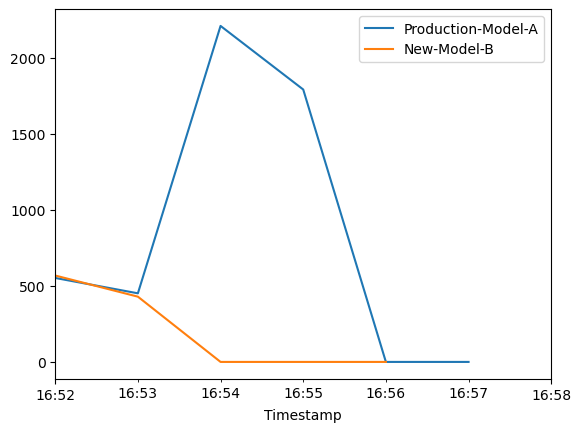

In [14]:
#plot-model-B-metrics
time.sleep(20)  # let metrics catch up
plot_endpoint_metrics()

Now that you have collected a list of predicted values for the second model, evaluate the R2 score, MAE, and RMSE metrics. 

In [18]:
#evaluate-model-B-metrics
df_with_labels = pd.read_csv("data/abalone_data_new.csv", header=None)
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()
print("The predicted values are:\n {}\n".format(preds2))
print("The actual values are:\n {}\n".format(labels))

# Calculate R2
score = r2_score(labels, preds2)
print("The R2 score of the new model is {}".format(round(score, 2)))

# Calculate MAE
score = mean_absolute_error(labels, preds2)
print("The Mean Absolute Error of the new model is {}".format(round(score, 2)))

# Calculate RMSE
score = root_mean_squared_error(labels, preds)
print("The Root Mean Squared Error of the current production model is {}".format(round(score, 2)))

The predicted values are:
 [14. 12. 13. ... 13. 14. 11.]

The actual values are:
 [13 11 10 ... 10 13 13]

The R2 score of the new model is -1.12
The Mean Absolute Error of the new model is 1.49
The Root Mean Squared Error of the current production model is 1.62


This model is not performing better than the current production model. The R2 score is lower, the MAE is higher, and the RMSE is higher. Once you have a new model to test, you can edit the endpoint configuration to deploy a new model before shifting production traffic to it.

You have successfully configured an A/B testing strategy, tested model variants, and reviewed the performance of the model variants.

### Cleanup

You have completed this notebook. To move to the next part of the lab, do the following:

- Close this notebook file.
- Return to the lab session and continue with **Task 3**.